# Training and Serving a TensorFlow Model to AI Platform Prediction

This notebooks trains a TensorFlow classification model locally, using the Keras API, and deploys the model to AI Platform for online prediction. The AI Platform model service is also configered to enable request-response logging to BigQuery.

Note that the aim is to build and deploy a **minimal model** to showcase the AI Platform **logging capabilities**, which enable **skew detection** on the serving data and the produced predictions.

The notebook covers the following steps:

1. Prepare the data and generate a schema 
2. Train and evaluate, a TensorFlow classification model using Keras API
3. Export the trained model as a SavedModel for serving
4. Deploy the trained model to AI Platform Prediction 
5. Enabled request-response logging to BigQuery
6. Parse and query logs from BigQuery


This example uses **TensorFlow 2.x**

### Setup

In [5]:
try:
  from google.colab import auth
  auth.authenticate_user()
  print("Colab user is authenticated.")
except: pass

Colab user is authenticated.


In [0]:
!pip install -q -U tensorflow==2.1 tensorflow_data_validation==0.15.0
!pip install -U -q google-api-python-client
!pip install -U -q pandas

In [7]:
import os
import tensorflow as tf
import tensorflow_data_validation as tfdv

print("TF version: {}".format(tf.__version__))
print("TFDV version: {}".format(tfdv.__version__))

TF version: 2.1.0
TFDV version: 0.15.0


**Set the following variables to match your GCP environment**:

In [0]:
PROJECT = 'sa-data-validation'
BUCKET =  'sa-data-validation'
GCS_DATA_LOCATION = 'gs://workshop-datasets/covertype/data_validation'
REGION = 'us-central1'
BUCKET = 'sa-data-validation'
LOCAL_WORKSPACE = './workspace'
LOCAL_DATA_DIR = os.path.join(LOCAL_WORKSPACE, 'data')
SCHEMA_DIR = os.path.join(LOCAL_WORKSPACE, 'schema')
BQ_DATASET_NAME = 'data_validation'
BQ_TABLE_NAME = 'covertype_classifier_logs'
MODEL_NAME = 'covertype_classifier'
VERSION_NAME = 'v2'
TRAINING_DIR = os.path.join(LOCAL_WORKSPACE, 'training')
MODEL_DIR = os.path.join(TRAINING_DIR, 'exported_model')

In [9]:
!gcloud config set project {PROJECT}

Updated property [core/project].


Create a local workspace

In [10]:
if tf.io.gfile.exists(LOCAL_WORKSPACE):
  print("Removing previous workspace artifacts...")
  tf.io.gfile.rmtree(LOCAL_WORKSPACE)

print("Creating a new workspace...")
tf.io.gfile.makedirs(LOCAL_WORKSPACE)
tf.io.gfile.makedirs(LOCAL_DATA_DIR)

Creating a new workspace...


## 1. Dataset preparation and schema generation

We use the [covertype](https://archive.ics.uci.edu/ml/datasets/covertype) from UCI Machine Learning Repository. The task is to Predict forest cover type from cartographic variables only. 

The dataset is preprocessed, split, and uploaded to uploaded to the `gs://workshop-datasets/covertype` public GCS location. 

We use this version of the preprocessed dataset in this notebook. For more information, see [Cover Type Dataset](https://github.com/GoogleCloudPlatform/mlops-on-gcp/tree/master/datasets/covertype)

### 1.1. Download the data

In [0]:
LOCAL_TRAIN_DATA = os.path.join(LOCAL_DATA_DIR, 'train.csv') 
LOCAL_EVAL_DATA = os.path.join(LOCAL_DATA_DIR, 'eval.csv') 

In [12]:
!gsutil cp gs://workshop-datasets/covertype/data_validation/training/dataset.csv {LOCAL_TRAIN_DATA}
!gsutil cp gs://workshop-datasets/covertype/data_validation/evaluation/dataset.csv {LOCAL_EVAL_DATA}
!wc -l {LOCAL_TRAIN_DATA}

Copying gs://workshop-datasets/covertype/data_validation/training/dataset.csv...
/ [1 files][ 22.2 MiB/ 22.2 MiB]                                                
Operation completed over 1 objects/22.2 MiB.                                     
Copying gs://workshop-datasets/covertype/data_validation/evaluation/dataset.csv...
/ [1 files][  3.9 MiB/  3.9 MiB]                                                
Operation completed over 1 objects/3.9 MiB.                                      
431010 ./workspace/data/train.csv


In [13]:
import pandas as pd
sample = pd.read_csv(LOCAL_TRAIN_DATA).head()
sample.T

ImportError: ignored

                                        0      1  ...          3          4
Elevation                            3034   2827  ...       3188       3091
Aspect                                235     26  ...        156         61
Slope                                  13     16  ...         13          8
Horizontal_Distance_To_Hydrology      655     85  ...        175        134
Vertical_Distance_To_Hydrology        134     13  ...         28         10
Horizontal_Distance_To_Roadways      5799   3511  ...       3666       1390
Hillshade_9am                         197    211  ...        235        227
Hillshade_Noon                        251    204  ...        241        223
Hillshade_3pm                         190    125  ...        134        129
Horizontal_Distance_To_Fire_Points   4094   6008  ...       1719       2868
Wilderness_Area                     Rawah  Rawah  ...  Commanche  Commanche
Soil_Type                            7745   7745  ...       7756       7202
Cover_Type  

### 1.2. Generate and visualize statisitics

In [14]:
train_stats = tfdv.generate_statistics_from_csv(
    data_location=LOCAL_TRAIN_DATA)

tfdv.visualize_statistics(train_stats)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


### 1.3. Generate the schema

In [0]:
schema = tfdv.infer_schema(train_stats)
tfdv.display_schema(schema=schema)

### 1.4. Fine tune the schema

In [0]:
from tensorflow_metadata.proto.v0 import schema_pb2, statistics_pb2

tfdv.set_domain(schema, 'Soil_Type', schema_pb2.IntDomain(
    name='Soil_Type', is_categorical=True))

tfdv.set_domain(schema, 'Cover_Type', schema_pb2.IntDomain(
    name='Cover_Type', is_categorical=True))

train_stats = tfdv.generate_statistics_from_csv(
    data_location=LOCAL_TRAIN_DATA,
    stats_options=tfdv.StatsOptions(
        schema=schema)
    )

schema = tfdv.infer_schema(train_stats)
tfdv.get_feature(schema, 'Soil_Type').type = schema_pb2.FeatureType.BYTES
tfdv.display_schema(schema=schema)
tfdv.write_schema_text(schema, SCHEMA_DIR)

### 1.5 Define metadata

In [0]:
schema = tfdv.load_schema_text(SCHEMA_DIR)

def vocab(feature_name):
  return tfdv.get_domain(schema, feature_name).value

HEADER = list(sample.columns)

TARGET_FEATURE_NAME = 'Cover_Type'

FEATURE_LABELS = vocab(TARGET_FEATURE_NAME)

NUMERIC_FEATURE_NAMES = [feature.name for feature in schema.feature 
                         if feature.type == 2
                         and feature.name != TARGET_FEATURE_NAME]

CATEGORICAL_FEATURE_NAMES = [feature.name for feature in schema.feature 
                         if feature.type == 1
                         and feature.name != TARGET_FEATURE_NAME]

FEATURE_NAMES = CATEGORICAL_FEATURE_NAMES + NUMERIC_FEATURE_NAMES

HEADER_DEFAULTS = [[0] if feature_name in NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME] else ['NA'] 
                   for feature_name in HEADER]

NUM_CLASSES = len(FEATURE_LABELS)

## 2. Model training and evaluation

### 2.1. Implement data input pipeline

In [0]:
RANDOM_SEED = 19830610
import multiprocessing

def create_dataset(file_pattern, 
                  batch_size=128, num_epochs=1, shuffle=False):
  
    dataset = tf.data.experimental.make_csv_dataset(
        file_pattern=file_pattern,
        batch_size=batch_size,
        column_names=HEADER,
        column_defaults=HEADER_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        field_delim=',',
        header=True,
        num_epochs=num_epochs,
        shuffle=shuffle,
        shuffle_buffer_size=(5 * batch_size),
        shuffle_seed=RANDOM_SEED,
        num_parallel_reads=multiprocessing.cpu_count(),
        sloppy=True,
    )
    return dataset.cache()

In [14]:
index = 1
for batch in create_dataset(LOCAL_TRAIN_DATA, batch_size=5, shuffle=False).take(2):
  print("Batch: {}".format(index))
  print("========================")
  record, target = batch
  print("Input features:")
  for key in record:
    print(" - {}:{}".format(key, record[key].numpy()))
  print("Target: {}".format(target))
  index += 1
  print()

Batch: 1
Input features:
 - Elevation:[3034 2827 2854 3188 3091]
 - Aspect:[235  26  27 156  61]
 - Slope:[13 16 12 13  8]
 - Horizontal_Distance_To_Hydrology:[655  85 484 175 134]
 - Vertical_Distance_To_Hydrology:[134  13  22  28  10]
 - Horizontal_Distance_To_Roadways:[5799 3511  618 3666 1390]
 - Hillshade_9am:[197 211 215 235 227]
 - Hillshade_Noon:[251 204 214 241 223]
 - Hillshade_3pm:[190 125 134 134 129]
 - Horizontal_Distance_To_Fire_Points:[4094 6008 1295 1719 2868]
 - Wilderness_Area:[b'Rawah' b'Rawah' b'Commanche' b'Commanche' b'Commanche']
 - Soil_Type:[b'7745' b'7745' b'4704' b'7756' b'7202']
Target: [1 1 1 1 0]

Batch: 2
Input features:
 - Elevation:[2993 3276 2864 3183 2587]
 - Aspect:[ 35 343 319 138  80]
 - Slope:[ 8 11 29 23  5]
 - Horizontal_Distance_To_Hydrology:[636 849 228 268 234]
 - Vertical_Distance_To_Hydrology:[ 90 -14  98  85  28]
 - Horizontal_Distance_To_Roadways:[3355 1776  577 3872 1350]
 - Hillshade_9am:[219 199 134 248 227]
 - Hillshade_Noon:[224 224

### 2.2. Create feature columns

In [0]:
import math

def create_feature_columns():
  feature_columns = []
  
  for feature_name in FEATURE_NAMES:
    # Categorical features
    if feature_name in CATEGORICAL_FEATURE_NAMES:
      
      vocabulary = vocab(feature_name)
      vocab_size = len(vocabulary)
      
      # Create embedding column for categotical feature column with vocabulary
      embedding_feature_column = tf.feature_column.embedding_column(
          categorical_column = tf.feature_column.categorical_column_with_vocabulary_list(
              key=feature_name,
              vocabulary_list=vocabulary), dimension=int(math.sqrt(vocab_size) + 1))
            
      feature_columns.append(embedding_feature_column)

    # Numeric features
    else:
      numeric_column = tf.feature_column.numeric_column(feature_name)
      feature_columns.append(numeric_column)

  return feature_columns


In [16]:
feature_columns = create_feature_columns()

for column in feature_columns:
  print(column)

EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='Soil_Type', vocabulary_list=('2702', '2703', '2704', '2705', '2706', '2717', '3501', '3502', '4201', '4703', '4704', '4744', '4758', '5101', '6101', '6102', '6731', '7101', '7102', '7103', '7201', '7202', '7700', '7701', '7702', '7709', '7710', '7745', '7746', '7755', '7756', '7757', '7790', '8703', '8707', '8708', '8771', '8772', '8776'), dtype=tf.string, default_value=-1, num_oov_buckets=0), dimension=7, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7f13dcd3f2e8>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True)
EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='Wilderness_Area', vocabulary_list=('Cache', 'Commanche', 'Neota', 'Rawah'), dtype=tf.string, default_value=-1, num_oov_buckets=0), dimension=3, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7f13dcc50e48>, ckpt_to_load_

### 2.3. Create and compile the model



In [0]:
def create_model(params):

  feature_columns = create_feature_columns()
  
  layers = []
  layers.append(tf.keras.layers.DenseFeatures(feature_columns))
  for units in params.hidden_units:
    layers.append(tf.keras.layers.Dense(units=units, activation='relu'))
    layers.append(tf.keras.layers.BatchNormalization())
    layers.append(tf.keras.layers.Dropout(rate=params.dropout))
  
  layers.append(tf.keras.layers.Dense(units=NUM_CLASSES, activation='softmax', name='output'))
  
  model = tf.keras.Sequential(layers=layers, name='classifier')
    
  adam_optimzer = tf.keras.optimizers.Adam(learning_rate=params.learning_rate)

  model.compile(
        optimizer=adam_optimzer, 
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()], 
        loss_weights=None,
        sample_weight_mode=None, 
        weighted_metrics=None, 
    )

  return model  

### 2.4. Train and evaluate experiment

#### Experiment

In [0]:
def run_experiment(model, params):

  # TensorBoard callback
  LOG_DIR = os.path.join(TRAINING_DIR, 'logs')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR)

  # Early stopping callback
  earlystopping_callback = tf.keras.callbacks.EarlyStopping(
      monitor='val_sparse_categorical_accuracy', 
      patience=3, 
      restore_best_weights=True
  )

  callbacks = [
        tensorboard_callback,
        earlystopping_callback]

  # train dataset
  train_dataset = create_dataset(
      LOCAL_TRAIN_DATA,
      batch_size=params.batch_size,
      shuffle=True)
    
  # eval dataset
  eval_dataset = create_dataset(
      LOCAL_EVAL_DATA,
      batch_size=params.batch_size)
    
  # Prep training directory
  if tf.io.gfile.exists(TRAINING_DIR):
    print("Removing previous training artefacts...")
    tf.io.gfile.rmtree(TRAINING_DIR)

  print("Creating training directory...")
  tf.io.gfile.mkdir(TRAINING_DIR)

  print("Experiment started...")
  print(".......................................")
  
  # Run train and evaluate.
  history = model.fit(
    x=train_dataset, 
    epochs=params.epochs, 
    callbacks=callbacks,
    validation_data=eval_dataset,
  )

  print(".......................................")
  print("Experiment finished.")
  print("")

  return history


#### Hyper parameters

In [0]:
class Parameters():
    pass

TRAIN_DATA_SIZE = 431010

params = Parameters()
params.learning_rate = 0.01
params.hidden_units = [128, 128]
params.dropout = 0.15
params.batch_size =  265
params.steps_per_epoch = int(math.ceil(TRAIN_DATA_SIZE / params.batch_size))
params.epochs = 10

#### Run experiment

In [20]:
model = create_model(params)
example_batch, target = list(create_dataset(LOCAL_TRAIN_DATA, batch_size=2, shuffle=True).take(1))[0]
model(example_batch)
model.summary()

Model: "classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features (DenseFeature multiple                  285       
_________________________________________________________________
dense (Dense)                multiple                  2688      
_________________________________________________________________
batch_normalization (BatchNo multiple                  512       
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  16512     
_________________________________________________________________
batch_normalization_1 (Batch multiple                  512       
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0

In [21]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

history = run_experiment(model, params)

Creating training directory...
Experiment started...
.......................................
Epoch 1/10
1627/1627 [==============================] - 27s 17ms/step - loss: 0.6628 - sparse_categorical_accuracy: 0.7185 - val_loss: 0.7148 - val_sparse_categorical_accuracy: 0.6792
Epoch 2/10
1627/1627 [==============================] - 14s 9ms/step - loss: 0.5905 - sparse_categorical_accuracy: 0.7465 - val_loss: 0.6481 - val_sparse_categorical_accuracy: 0.7169
Epoch 3/10
1627/1627 [==============================] - 15s 9ms/step - loss: 0.5661 - sparse_categorical_accuracy: 0.7565 - val_loss: 0.5732 - val_sparse_categorical_accuracy: 0.7448
Epoch 4/10
1627/1627 [==============================] - 14s 9ms/step - loss: 0.5509 - sparse_categorical_accuracy: 0.7644 - val_loss: 0.5392 - val_sparse_categorical_accuracy: 0.7662
Epoch 5/10
1627/1627 [==============================] - 14s 9ms/step - loss: 0.5378 - sparse_categorical_accuracy: 0.7694 - val_loss: 0.5080 - val_sparse_categorical_accuracy

#### Visualize training history

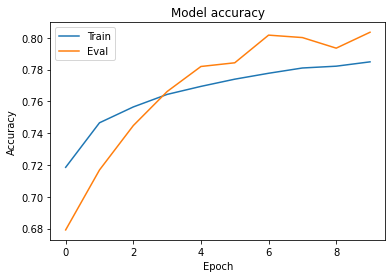

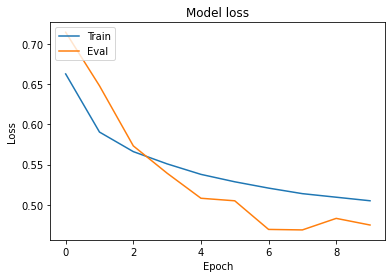

In [22]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Eval'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Eval'], loc='upper left')
plt.show()

## 3. Model export for serving

### 3.1. Implement serving input receiver functions

In [23]:
feature_spec = {}
for feature_name in FEATURE_NAMES:
    if feature_name in CATEGORICAL_FEATURE_NAMES:
        feature_spec[feature_name] = tf.io.FixedLenFeature(shape=(1,), dtype=tf.string)
    else:
        feature_spec[feature_name] = tf.io.FixedLenFeature(shape=(1,), dtype=tf.float32)

for key, value in feature_spec.items():
  print("{}: {}".format(key, value))

Soil_Type: FixedLenFeature(shape=(1,), dtype=tf.string, default_value=None)
Wilderness_Area: FixedLenFeature(shape=(1,), dtype=tf.string, default_value=None)
Aspect: FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None)
Elevation: FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None)
Hillshade_3pm: FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None)
Hillshade_9am: FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None)
Hillshade_Noon: FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None)
Horizontal_Distance_To_Fire_Points: FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None)
Horizontal_Distance_To_Hydrology: FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None)
Horizontal_Distance_To_Roadways: FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None)
Slope: FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None)
Vertical_Distance_To_Hydrology: FixedLenFeature(shape=(1,), dtype=tf.floa

#### Features serving function

In [0]:
def make_features_serving_fn(model):

  @tf.function
  def serve_features_fn(features):
    
    return model(features)

  return serve_features_fn

### 3.2. Export the model

In [25]:
features_input_signature = {
                feature: tf.TensorSpec(shape=spec.shape, dtype=spec.dtype, name=feature)
                for feature, spec in feature_spec.items()
            }

features_input_signature['request_timestamp'] = tf.TensorSpec(shape=[None], dtype=tf.string, name='request_timestamp')

signatures = {        
    'serving_default': make_features_serving_fn(model).get_concrete_function(
        features_input_signature),
    }

model.save(MODEL_DIR, save_format='tf', signatures=signatures)
print("Model is exported to: {}.".format(MODEL_DIR))

Model is exported to: ./workspace/training/exported_model.


In [32]:
!saved_model_cli show --dir {MODEL_DIR} --tag_set serve --signature_def serving_default

2020-04-07 14:28:38.436585: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2020-04-07 14:28:38.436726: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2020-04-07 14:28:38.436752: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
The given SavedModel SignatureDef contains the following input(s):
  inputs['Aspect'] tensor_info:
      dtype: DT_FLOAT
      shape: (1)
      name: ser

### 3.3. Test exported model

In [0]:
instances = [
      { 'request_timestamp': '20200101',
        'Soil_Type': '7202',
        'Wilderness_Area': 'Commanche',
        'Aspect': 61,
        'Elevation': 3091,
        'Hillshade_3pm': 129,
        'Hillshade_9am': 227,
        'Hillshade_Noon': 223,
        'Horizontal_Distance_To_Fire_Points': 2868,
        'Horizontal_Distance_To_Hydrology': 134,
        'Horizontal_Distance_To_Roadways': 0, 
        'Slope': 8, 
        'Vertical_Distance_To_Hydrology': 10,
    }
]

#### Preidct using features_serving signature

In [0]:
import numpy as np

def create_tf_features(instance):
 
  new_instance = {}
  for key, value in instance.items():
    if key in CATEGORICAL_FEATURE_NAMES or key == 'request_timestamp':
      new_instance[key] = tf.constant(value, dtype=tf.string)
    else:
      new_instance[key] = tf.constant(value, dtype=tf.float32)
  
  return new_instance

In [0]:
features_predictor = tf.saved_model.load(MODEL_DIR).signatures["serving_default"]

def predict_features_serving(instance):

  features = create_tf_features(instance)
  probabilities = features_predictor(**features)['output_0'].numpy()
  predictions = FEATURE_LABELS[int(np.argmax(probabilities))]

  return predictions

In [57]:
predict_features_serving(instances[0])

'1'

### 3.4  Upload exported model to GCS

In [33]:
!gsutil cp -r {MODEL_DIR} gs://{BUCKET}/models/{MODEL_NAME}

Copying file://./workspace/training/exported_model/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://./workspace/training/exported_model/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
Copying file://./workspace/training/exported_model/variables/variables.index [Content-Type=application/octet-stream]...
-
Operation completed over 3 objects/1.1 MiB.                                      


## 4. Model deployment to AI Platform 


### 4.1. Create model in AI Platform

In [0]:
!gcloud ai-platform models create {MODEL_NAME} \
  --project {PROJECT} \
  --regions {REGION}

In [34]:
!gcloud ai-platform models list --project {PROJECT}

NAME                  DEFAULT_VERSION_NAME
covertype_classifier  v1


### 4.2. Create a model version

In [35]:
!gcloud ai-platform versions create {VERSION_NAME} \
  --model={MODEL_NAME} \
  --origin=gs://{BUCKET}/models/{MODEL_NAME} \
  --runtime-version=2.1 \
  --framework=TENSORFLOW \
  --python-version=3.7 \
  --project={PROJECT}

!gcloud ai-platform versions list --model={MODEL_NAME} --project={PROJECT}

NAME  DEPLOYMENT_URI                                       STATE
v1    gs://sa-data-validation/models/covertype_classifier  READY
v2    gs://sa-data-validation/models/covertype_classifier  READY


### 4.3. Test deployed model

In [21]:
import googleapiclient.discovery

service = googleapiclient.discovery.build('ml', 'v1')
name = 'projects/{}/models/{}/versions/{}'.format(PROJECT, MODEL_NAME, VERSION_NAME)
print("Service name: {}".format(name))

def caip_predict(instances):
  
  serving_instances = []
  for instance in instances:
    serving_instances.append(
        {key: [value] for key, value in instance.items()})
  
  response = service.projects().predict(
      
      name=name,
      body={
          'signature_name': 'serving_default',
          'instances': serving_instances}
  ).execute()

  if 'error' in response:
    raise RuntimeError(response['error'])

  probability_list = [output['output_0'] for output in response['predictions']]
  classes = [FEATURE_LABELS[int(np.argmax(probabilities))] for probabilities in probability_list]
  return classes

Service name: projects/sa-data-validation/models/covertype_classifier/versions/v2


In [22]:
caip_predict(instances)

['1']

## 5. BigQuery logging dataset preparation

### 5.1. Create BQ Dataset

In [88]:
from google.cloud import bigquery

client = bigquery.Client(PROJECT)
dataset_names = [dataset.dataset_id for dataset in client.list_datasets(PROJECT)]

dataset = bigquery.Dataset("{}.{}".format(PROJECT, BQ_DATASET_NAME))
dataset.location = "US"

if BQ_DATASET_NAME not in dataset_names:
  dataset = client.create_dataset(dataset)
  print("Created dataset {}.{}".format(client.project, dataset.dataset_id))

print("BigQuery Dataset is ready.")


BigQuery Dataset is ready.


### 5.2. Create BQ Table


#### Table schema

In [0]:
import json

table_schema_json = [
  {
    "name": "model", 
    "type": "STRING", 
    "mode": "REQUIRED"
   },
   {
     "name":"model_version", 
     "type": "STRING", 
     "mode":"REQUIRED"
  },
  {
    "name":"time", 
    "type": "TIMESTAMP", 
    "mode": "REQUIRED"
  },
  {
    "name":"raw_data", 
    "type": "STRING", 
    "mode": "REQUIRED"
  },
  {
    "name":"raw_prediction", 
    "type": "STRING", 
    "mode": "NULLABLE"
  },
  {
    "name":"groundtruth", 
    "type": "STRING", 
    "mode": "NULLABLE"
  },
]

json.dump(table_schema_json, open('table_schema.json', 'w'))

#### Ceating an ingestion-time partitioned tables

In [0]:
table = bigquery.Table(
    "{}.{}.{}".format(PROJECT, BQ_DATASET_NAME, BQ_TABLE_NAME))

table_names = [table.table_id for table in client.list_tables(dataset)]

if BQ_TABLE_NAME in table_names:
  print("Deleteing BQ Table: {} ...".format(BQ_TABLE_NAME))
  client.delete_table(table)

# table = client.create_table(table)
# table.partition_expiration = 60 * 60 * 24 * 7
# print("Created table {}.{}.{}".format(table.project, table.dataset_id, table.table_id))


In [0]:
TIME_PARTITION_EXPERIATION = 60 * 60 * 24 * 7 # week

!bq mk --table \
  --project_id={PROJECT} \
  --time_partitioning_type=DAY \
  --time_partitioning_expiration {TIME_PARTITION_EXPERIATION} \
  {PROJECT}:{BQ_DATASET_NAME}.{BQ_TABLE_NAME} \
  'table_schema.json'

### 5.3. Configre the AI Platform model version to enable request-response logging to BigQuery

In [0]:
sampling_percentage = 1.0
bq_full_table_name = '{}.{}.{}'.format(PROJECT, BQ_DATASET_NAME, BQ_TABLE_NAME)

In [48]:
logging_config = {
    "requestLoggingConfig":{
        "samplingPercentage": sampling_percentage,
        "bigqueryTableName": bq_full_table_name
        }
    }

response = service.projects().models().versions().patch(
    name=name,
    body=logging_config,
    updateMask="requestLoggingConfig"
    ).execute()

response

{'metadata': {'@type': 'type.googleapis.com/google.cloud.ml.v1.OperationMetadata',
  'createTime': '2020-04-07T15:30:25Z',
  'modelName': 'projects/sa-data-validation/models/covertype_classifier',
  'operationType': 'UPDATE_VERSION',
  'version': {'createTime': '2020-04-07T15:14:06Z',
   'deploymentUri': 'gs://sa-data-validation/models/covertype_classifier',
   'etag': '2gdK/2bTEx8=',
   'framework': 'TENSORFLOW',
   'machineType': 'mls1-c1-m2',
   'name': 'projects/sa-data-validation/models/covertype_classifier/versions/v2',
   'pythonVersion': '3.7',
   'requestLoggingConfig': {'bigqueryTableName': 'sa-data-validation.data_validation.covertype_classifier_logs',
    'samplingPercentage': 1},
   'runtimeVersion': '2.1',
   'state': 'READY'}},
 'name': 'projects/sa-data-validation/operations/update_covertype_classifier_v2_1586273425000'}

### 5.4. Test request-response logging

In [54]:
import time

for i in range(20):
  print('.', end='')
  time.sleep(0.5)

['1']['1']['1']['1']['1']['1']['1']['1']['1']['1']['1']['1']['1']['1']['1']['1']['1']['1']['1']['1']

In [62]:
query = '''
  SELECT * FROM 
  `{}.{}` 
  WHERE model_version = '{}'
  ORDER BY time desc
  LIMIT {}
'''.format(BQ_DATASET_NAME, BQ_TABLE_NAME, VERSION_NAME, 3)

pd.io.gbq.read_gbq(
    query, project_id=PROJECT).T


,0,1,2
model,covertype_classifier,covertype_classifier,covertype_classifier
model_version,v2,v2,v2
time,2020-04-07 16:03:36+00:00,2020-04-07 16:03:36+00:00,2020-04-07 16:03:35+00:00
raw_data,"{""instances"": [{""request_timestamp"": [""20200101""], ""Soil_Type"": [""7202""], ""Wilderness_Area"": [""Commanche""], ""Aspect"": [61], ""Elevation"": [3091], ""Hillshade_3pm"": [129], ""Hillshade_9am"": [227], ""Hillshade_Noon"": [223], ""Horizontal_Distance_To_Fire_Points"": [2868], ""Horizontal_Distance_To_Hydrology"": [134], ""Horizontal_Distance_To_Roadways"": [0], ""Slope"": [8], ""Vertical_Distance_To_Hydrology"": [10]}]}","{""instances"": [{""request_timestamp"": [""20200101""], ""Soil_Type"": [""7202""], ""Wilderness_Area"": [""Commanche""], ""Aspect"": [61], ""Elevation"": [3091], ""Hillshade_3pm"": [129], ""Hillshade_9am"": [227], ""Hillshade_Noon"": [223], ""Horizontal_Distance_To_Fire_Points"": [2868], ""Horizontal_Distance_To_Hydrology"": [134], ""Horizontal_Distance_To_Roadways"": [0], ""Slope"": [8], ""Vertical_Distance_To_Hydrology"": [10]}]}","{""instances"": [{""request_timestamp"": [""20200101""], ""Soil_Type"": [""7202""], ""Wilderness_Area"": [""Commanche""], ""Aspect"": [61], ""Elevation"": [3091], ""Hillshade_3pm"": [129], ""Hillshade_9am"": [227], ""Hillshade_Noon"": [223], ""Horizontal_Distance_To_Fire_Points"": [2868], ""Horizontal_Distance_To_Hydrology"": [134], ""Horizontal_Distance_To_Roadways"": [0], ""Slope"": [8], ""Vertical_Distance_To_Hydrology"": [10]}]}"
raw_prediction,"{""predictions"": [{""output_0"": [0.31033429503440857, 0.6896360516548157, 1.1421931976618449e-11, 1.6456447315960077e-09, 2.9508630177588202e-05, 1.345885802805924e-08, 1.7852252653938194e-07]}]}","{""predictions"": [{""output_0"": [0.31033429503440857, 0.6896360516548157, 1.1421931976618449e-11, 1.6456447315960077e-09, 2.9508630177588202e-05, 1.345885802805924e-08, 1.7852252653938194e-07]}]}","{""predictions"": [{""output_0"": [0.31033429503440857, 0.6896360516548157, 1.1421931976618449e-11, 1.6456447315960077e-09, 2.9508630177588202e-05, 1.345885802805924e-08, 1.7852252653938194e-07]}]}"
groundtruth,None,None,None


## 6. BigQuery logs parsing

In [0]:
view_name = "vw_"+BQ_TABLE_NAME+"_"+VERSION_NAME

colum_names = ['request_timestamp'] + FEATURE_NAMES
input_features = ', \r\n  '.join(colum_names)

json_features_extraction = []
for feature_name in colum_names:
  s = "JSON_EXTRACT(instance, '$.{}')".format(feature_name) 
  if feature_name in NUMERIC_FEATURE_NAMES:
    s = "CAST({} AS NUMERIC)".format(s)
  s += " AS {}".format(feature_name)
  json_features_extraction.append(s)
json_features_extraction = ', \r\n    '.join(json_features_extraction)

class_probability_pivoting = []
for class_index, class_label in enumerate(FEATURE_LABELS):
  s = "MAX(IF(class_index = {}, class_probability, NULL)) as prob_{}".format(class_index, class_label)
  class_probability_pivoting.append(s)
class_probability_pivoting = ', \r\n  '.join(class_probability_pivoting)

### 6.1. Create a view to parse the logs

In [0]:
sql_script = '''
CREATE OR REPLACE VIEW @dataset_name.@view_name
AS

WITH step1
AS
(
  SELECT 
    model, 
    model_version, 
    time, 
    SPLIT(JSON_EXTRACT(raw_data, '$.instances'), '}],[{') instance_list, 
    SPLIT(JSON_EXTRACT(raw_prediction, '$.predictions'), '}],[{') as prediction_list
  FROM 
  `@project.@dataset_name.@table_name` 
  WHERE model_version = '@version'
),

step2
AS
(
  SELECT
    model, 
    model_version, 
    time, 
    REPLACE(REPLACE(instance, '[', ''),']', '') AS instance,
    REPLACE(REPLACE(prediction, '[{"output_0":[', ''),']}]', '') AS prediction,
  FROM step1
  JOIN UNNEST(step1.instance_list) AS instance
  WITH OFFSET AS f1
  JOIN UNNEST(step1.prediction_list) AS prediction
  WITH OFFSET AS f2
  ON f1=f2
),

step3 AS
(
  SELECT 
    model, 
    model_version, 
    time,
    @json_features_extraction,
    SPLIT(prediction, ',') AS class_probabilities, 
  FROM step2
),

step4
AS
(
  SELECT * EXCEPT(class_probabilities)
  FROM step3
  JOIN UNNEST(step3.class_probabilities) AS class_probability
  WITH OFFSET AS class_index
)

SELECT
  model,
  model_version,
  time,
  @input_features,
  @class_probability_pivoting
FROM step4
GROUP BY
  model,
  model_version,
  time,
  request_timestamp,
  Soil_Type,
  Wilderness_Area,
  Aspect,
  Elevation,
  Hillshade_3pm,
  Hillshade_9am	,
  Hillshade_Noon,
  Horizontal_Distance_To_Fire_Points,
  Horizontal_Distance_To_Hydrology,
  Horizontal_Distance_To_Roadways,
  Slope,	
  Vertical_Distance_To_Hydrology
'''

In [0]:
sql_script = sql_script.replace("@project", PROJECT)
sql_script = sql_script.replace("@dataset_name", BQ_DATASET_NAME)
sql_script = sql_script.replace("@table_name", BQ_TABLE_NAME)
sql_script = sql_script.replace("@view_name", view_name)
sql_script = sql_script.replace("@version", VERSION_NAME)
sql_script = sql_script.replace("@input_features", input_features)
sql_script = sql_script.replace("@json_features_extraction", json_features_extraction)
sql_script = sql_script.replace("@class_probability_pivoting", class_probability_pivoting)
#print(sql_script)

In [95]:
client.query(query = sql_script)
print("View was created or replaced.")

View was created or replaced.


### 6.2. Query the view

In [105]:
query = '''
  SELECT * FROM 
  `{}.{}` 
  LIMIT {}
'''.format(BQ_DATASET_NAME, view_name, 3)

pd.io.gbq.read_gbq(
    query, project_id=PROJECT).T

,0,1,2
model,covertype_classifier,covertype_classifier,covertype_classifier
model_version,v2,v2,v2
time,2020-04-08 06:57:43+00:00,2020-04-08 06:57:27+00:00,2020-04-07 16:03:20+00:00
request_timestamp,"""20200101""","""20200101""","""20200101"""
Soil_Type,"""7202""","""7202""","""7202"""
Wilderness_Area,"""Commanche""","""Commanche""","""Commanche"""
Aspect,61,61,61
Elevation,3091,3091,3091
Hillshade_3pm,129,129,129
Hillshade_9am,227,227,227
